In [1]:
#Подгружаем необходимые библиотеки для работы с данными и машинного обучения
import warnings
import timeit

import pandas as pd

import catboost
import phik
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import (LinearRegression, 
                                  Ridge, 
                                  Lasso,
                                  ElasticNet)
from catboost import CatBoostRegressor
from sklearn.metrics import (mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error,
                             f1_score, 
                             roc_curve, 
                             roc_auc_score, 
                             confusion_matrix,
                             accuracy_score,
                             make_scorer)
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.dummy import DummyRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats as st
from statsmodels.tsa.seasonal import seasonal_decompose

#Подгружаем дополнительные полезные библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#Уберем warnings, чтобы не мешали
warnings.filterwarnings("ignore")

In [3]:
#Загружаем данные
data = pd.read_excel('C:/Users/kiril/OneDrive/Рабочий стол/Работа/Es_АфанасьевА/Характеристика моделей + результат.xlsx', sheet_name = 'Лист2')

In [4]:
data.head()

,Name,m_avg_Vol,VertRang,NTG,Minor_rang,Major_rang,Major_to_Minor,SEED,GSR,m_avg_And,K_avg,NTG_avg,Rasch_avg,h_eff,Кh_avg,h_layer_avg,Ed,Ev,Ea,Es
0,ID1,0.196,1.5,50,1000,2000,2,500,1,0.193657,392.088433,0.606485,11.806539,21.224132,8321.54803,1.883559,0.363409,0.470564,0.897620,0.153500
1,ID6,0.196,1.5,50,2000,4000,2,500,1,0.195075,390.687337,0.618044,12.979414,22.496834,8799.27856,1.806031,0.378639,0.355970,0.895295,0.120672
2,ID11,0.196,1.5,50,3000,6000,2,500,1,0.187047,259.511183,0.616593,13.438737,22.695795,5898.13349,1.803719,0.376182,0.389253,0.937711,0.137309
3,ID16,0.196,1.5,50,4000,8000,2,500,1,0.190136,295.183556,0.571482,14.733000,22.153432,6547.04823,1.656626,0.366793,0.385954,0.871646,0.123395
4,ID21,0.196,1.5,50,5000,10000,2,500,1,0.189361,231.167852,0.572265,14.622234,22.314711,5158.44278,1.623556,0.392443,0.377542,0.923350,0.136807


In [5]:
#Инфо о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            540 non-null    object 
 1   m_avg_Vol       540 non-null    float64
 2   VertRang        540 non-null    float64
 3   NTG             540 non-null    int64  
 4   Minor_rang      540 non-null    int64  
 5   Major_rang      540 non-null    int64  
 6   Major_to_Minor  540 non-null    int64  
 7   SEED            540 non-null    int64  
 8   GSR             540 non-null    int64  
 9   m_avg_And       540 non-null    float64
 10  K_avg           540 non-null    float64
 11  NTG_avg         540 non-null    float64
 12  Rasch_avg       540 non-null    float64
 13  h_eff           540 non-null    float64
 14  Кh_avg          540 non-null    float64
 15  h_layer_avg     540 non-null    float64
 16  Ed              540 non-null    float64
 17  Ev              540 non-null    flo

In [6]:
#Описание датафрейма
data.describe().transpose().round(3)

,count,mean,std,min,25%,50%,75%,max
m_avg_Vol,540.0,0.196,0.007,0.171,0.196,0.196,0.196,0.221
VertRang,540.0,2.583,2.367,0.500,1.500,1.500,1.625,10.000
NTG,540.0,51.528,9.047,30.000,50.000,50.000,50.000,80.000
Minor_rang,540.0,2963.889,841.465,1000.000,3000.000,3000.000,3000.000,6000.000
Major_rang,540.0,6000.000,1055.070,2000.000,6000.000,6000.000,6000.000,10000.000
Major_to_Minor,540.0,2.139,0.631,1.000,2.000,2.000,2.000,5.000
SEED,540.0,17100.000,17698.024,500.000,5000.000,10000.000,20000.000,50000.000
GSR,540.0,2.000,0.817,1.000,1.000,2.000,3.000,3.000
m_avg_And,540.0,0.189,0.004,0.172,0.188,0.190,0.191,0.203
K_avg,540.0,300.034,76.784,98.779,254.733,297.152,334.691,628.386


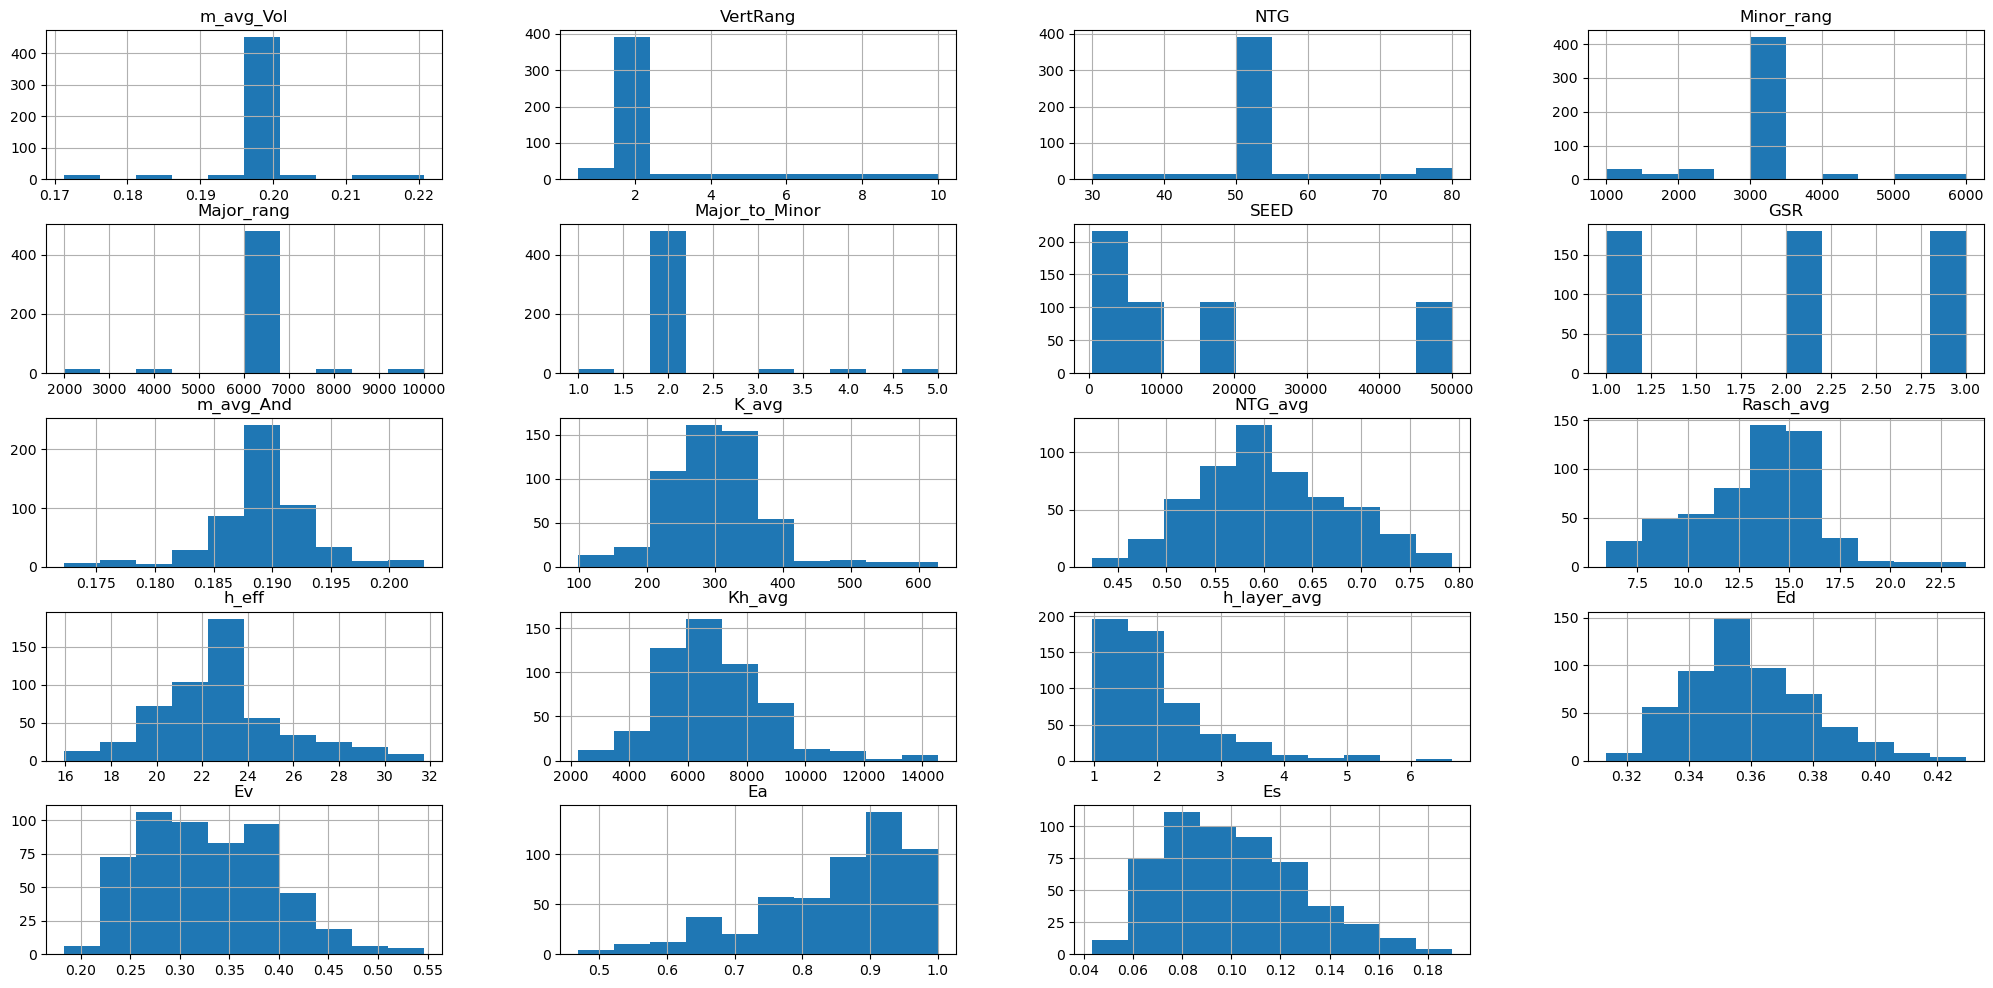

In [7]:
#Распределения для датафрейма
data.hist(figsize=(25,12));

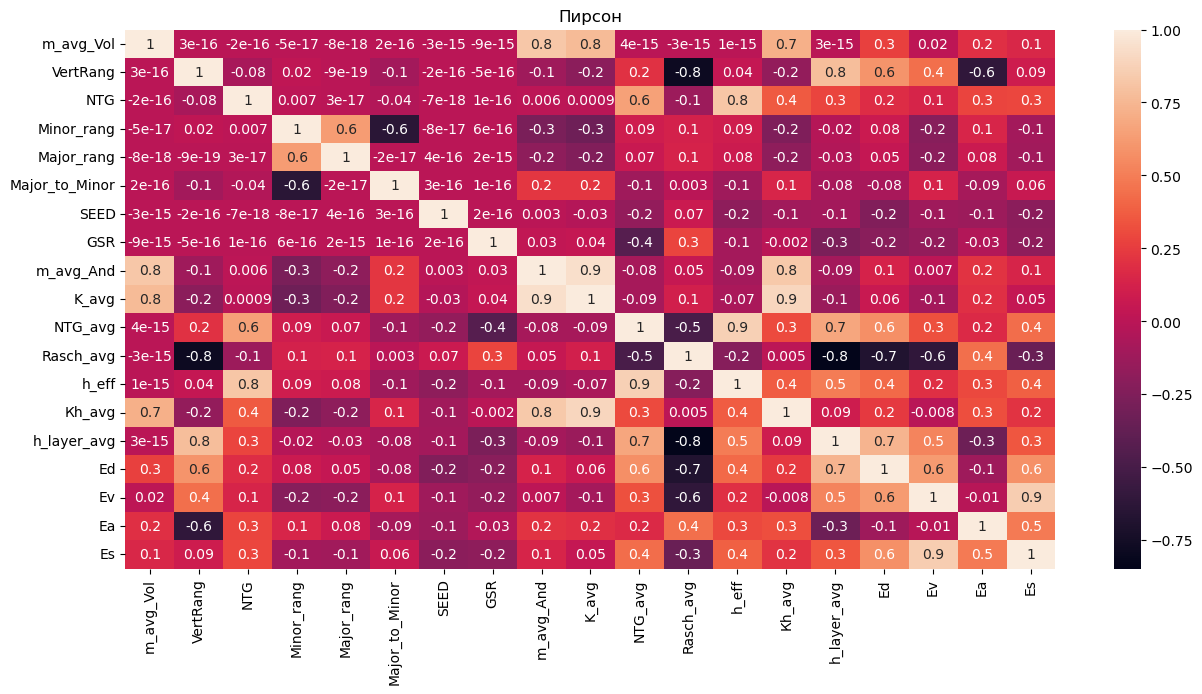

In [8]:
#Выведем тепловую карту, чтобы понять, какие параметры наибольшим образом коррелируют между собой
plt.figure(figsize=(15,7))
plt.title('Пирсон')
sns.heatmap(data.corr(method='pearson'), annot=True, fmt='.1g');

In [9]:
data_1 = data.copy()

#Удаляем ненужные столбцы для модели с прогнозом Es
data_ES = data_1.drop(['Name', 'm_avg_Vol', 'Ed', 'Ev', 'Ea'], axis=1)
data_ES.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   VertRang        540 non-null    float64
 1   NTG             540 non-null    int64  
 2   Minor_rang      540 non-null    int64  
 3   Major_rang      540 non-null    int64  
 4   Major_to_Minor  540 non-null    int64  
 5   SEED            540 non-null    int64  
 6   GSR             540 non-null    int64  
 7   m_avg_And       540 non-null    float64
 8   K_avg           540 non-null    float64
 9   NTG_avg         540 non-null    float64
 10  Rasch_avg       540 non-null    float64
 11  h_eff           540 non-null    float64
 12  Кh_avg          540 non-null    float64
 13  h_layer_avg     540 non-null    float64
 14  Es              540 non-null    float64
dtypes: float64(9), int64(6)
memory usage: 63.4 KB


In [10]:
#Разделим данные на выборки 80:20
features_Es = data_ES.drop('Es', axis=1)
target_Es = data_ES['Es']

features_train_Es, features_test_Es, target_train_Es, target_test_Es = train_test_split(
    features_Es, target_Es, test_size=0.2, random_state=12345)

print(features_train_Es.shape)
print(target_train_Es.shape)
print(features_test_Es.shape)
print(target_test_Es.shape)

(432, 14)
(432,)
(108, 14)
(108,)


In [11]:
best_score_set = []

In [12]:
#Используем DecisionTreeRegressor вместе с RandomizedSearchCV
DT = DecisionTreeRegressor(random_state=12345)

rs_space={'max_depth':[None] + [i for i in range(2, 7)]}

DT_random = RandomizedSearchCV(DT, rs_space, n_iter=100, scoring='neg_mean_absolute_percentage_error', cv=5)
model_random = DT_random.fit(features_train_Es, target_train_Es)

best_model_DT = model_random.best_estimator_

best_score_set.append((-1) * round(model_random.best_score_, 3))

print(20 * '-')
print('Для DT:')
print('Лучшая модель:', best_model_DT)
print('Лучшие гиперпараметры:', model_random.best_params_)
print('Лучший MAPE:', (-1) * round(model_random.best_score_, 3))

--------------------
Для DT:
Лучшая модель: DecisionTreeRegressor(random_state=12345)
Лучшие гиперпараметры: {'max_depth': None}
Лучший MAPE: 0.154


In [13]:
#Используем RandomForestRegressor вместе с RandomizedSearchCV
RF = RandomForestRegressor(verbose=0, n_jobs=-1, random_state=12345)

rs_space={'max_depth':[None] + [i for i in range(2, 7)],
          'n_estimators':np.arange(1, 100, 2),
         }

RF_random = RandomizedSearchCV(RF, rs_space, n_iter=100, scoring='neg_mean_absolute_percentage_error', cv=5)
model_random = RF_random.fit(features_train_Es, target_train_Es)

best_model_RF = model_random.best_estimator_

best_score_set.append((-1) * round(model_random.best_score_, 3))

print(20 * '-')
print('Для RF:')
print('Лучшая модель:', best_model_RF)
print('Лучшие гиперпараметры:', model_random.best_params_)
print('Лучший MAPE:', (-1) * round(model_random.best_score_, 3))

--------------------
Для RF:
Лучшая модель: RandomForestRegressor(n_estimators=63, n_jobs=-1, random_state=12345)
Лучшие гиперпараметры: {'n_estimators': 63, 'max_depth': None}
Лучший MAPE: 0.125


In [14]:
#Используем LinearRegression вместе с RandomizedSearchCV
LR = LinearRegression()

rs_space={}

LR_random = RandomizedSearchCV(LR, rs_space, n_iter=1, scoring='neg_mean_absolute_percentage_error', cv=5)
model_random = LR_random.fit(features_train_Es, target_train_Es)

best_model_LR = LinearRegression()

best_score_set.append((-1) * round(model_random.best_score_, 3))

print('Лучший MAPE:', (-1) * round(model_random.best_score_, 3))

Лучший MAPE: 0.189


In [15]:
#Используем LightGBM вместе с RandomizedSearchCV
LGBM = lgb.LGBMRegressor(verbose=-1, n_jobs=-1, random_state=12345)

rs_space={'max_depth':([None] + [i for i in range(2, 7)]),
          'n_estimators':np.arange(10, 500, 50),
         }

LGBM_random = RandomizedSearchCV(LGBM, rs_space, n_iter=100, scoring='neg_mean_absolute_percentage_error', cv=5)
model_random = LGBM_random.fit(features_train_Es, target_train_Es)

best_model_LightGBM = model_random.best_estimator_

best_score_set.append((-1) * round(model_random.best_score_, 3))

print(20 * '-')
print('Для LGBM:')
print('Лучшая модель:', best_model_LightGBM)
print('Лучшие гиперпараметры:', model_random.best_params_)
print('Лучший MAPE:', (-1) * round(model_random.best_score_, 3))

--------------------
Для LGBM:
Лучшая модель: LGBMRegressor(max_depth=4, n_estimators=460, random_state=12345, verbose=-1)
Лучшие гиперпараметры: {'n_estimators': 460, 'max_depth': 4}
Лучший MAPE: 0.111


In [16]:
#Используем Catboost вместе с RandomizedSearchCV
catboost = CatBoostRegressor(verbose=0, random_state=12345)

rs_space={'depth':[i for i in range(1, 7)],
          'iterations':np.arange(10, 500, 50),
         }

catboost_random = RandomizedSearchCV(catboost, rs_space, n_iter=100, scoring='neg_mean_absolute_percentage_error', cv=5)
model_random = catboost_random.fit(features_train_Es, target_train_Es)

best_model_catboost = model_random.best_estimator_

best_score_set.append((-1) * round(model_random.best_score_, 3))

print(20 * '-')
print('Для catboost:')
print('Лучшая модель:', best_model_catboost)
print('Лучшие гиперпараметры:', model_random.best_params_)
print('Лучший MAPE:', (-1) * round(model_random.best_score_, 3))

--------------------
Для catboost:
Лучшая модель: <catboost.core.CatBoostRegressor object at 0x00000255A5687D30>
Лучшие гиперпараметры: {'iterations': 210, 'depth': 6}
Лучший MAPE: 0.106


In [17]:
#Найдем время обучения и предсказания без RandomizedSearchCV и кросс-валидации
#Также добавим МAE после кросс-валидации и RandomizedSearchCV
time_fit_set = []
time_pred_set = []

for i in [best_model_DT,
          best_model_RF,
          best_model_LR,
          best_model_LightGBM,
          best_model_catboost]:
    
    model = i
    
    #Обучаем и фиксируем время обучения
    start_time_fit = timeit.default_timer()
    model.fit(features_train_Es, target_train_Es)
    time_fit = timeit.default_timer() - start_time_fit
    
    #Делаем прогноз и фиксируем время прогноза
    start_time_pred = timeit.default_timer()
    model.predict(features_test_Es)
    time_pred = timeit.default_timer() - start_time_pred
    
    time_fit_set.append(round(time_fit, 3))
    time_pred_set.append(round(time_pred, 3))
    
pivot_model = pd.DataFrame({'MAPE' : best_score_set, 
                            'Время обучения' : time_fit_set, 
                            'Время прогноза' : time_pred_set,
                           }, 
                            index=['Дерево решений', 'Случайный лес', 'Линейная регрессия', 'LGBM', 'Catboost'])

pivot_model

,MAPE,Время обучения,Время прогноза
Дерево решений,0.154,0.007,0.001
Случайный лес,0.125,0.173,0.023
Линейная регрессия,0.189,0.004,0.002
LGBM,0.111,0.178,0.002
Catboost,0.106,0.290,0.003


In [18]:
#Найдем MAE на тестовой выборке
model = best_model_catboost 
model.fit(features_train_Es, target_train_Es)
predictions = model.predict(features_test_Es)
mape_test = mean_absolute_percentage_error(target_test_Es, predictions)
print('-' * 20)
print('MAPE тестовой выборки:', round(mape_test, 3))

--------------------
MAPE тестовой выборки: 0.097


In [19]:
#Сравним результаты тестовой модели с константной
dummy_clf = DummyRegressor()
dummy_clf.fit(features_train_Es, target_train_Es)
predict_dummy = dummy_clf.predict(features_test_Es)
mape_dummy = mean_absolute_percentage_error(target_test_Es, predict_dummy) ** 0.5
print('MAPE константной модели составляет:', mape_dummy.round(3))

MAPE константной модели составляет: 0.464


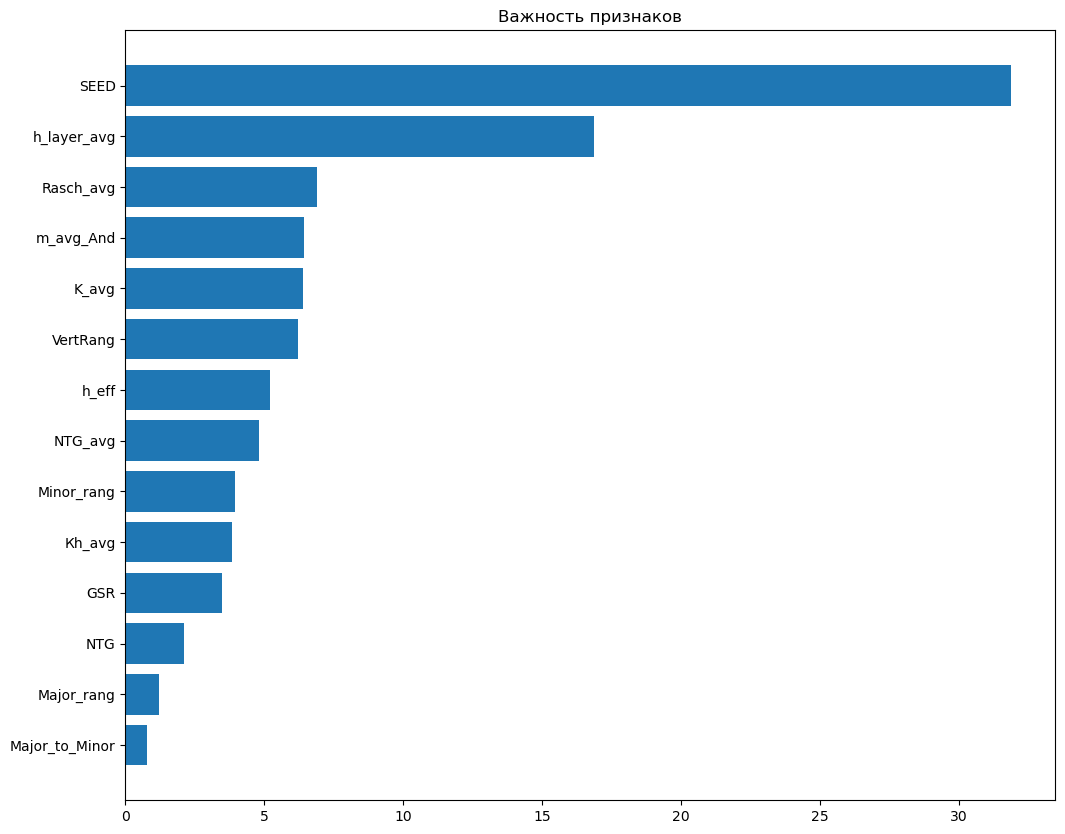

In [20]:
#Построим график важности признаков
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center');
plt.yticks(range(len(sorted_idx)), np.array(features_test_Es.columns)[sorted_idx]);
plt.title('Важность признаков');

In [21]:
#Сделаем датафрейм для свода факта и прогноза
test_pred = pd.DataFrame()
test_pred['test'] = target_test_Es
test_pred['pred'] = predictions
test_pred['dummy'] = predict_dummy
test_pred.head()

,test,pred,dummy
246,0.074300,0.080974,0.100913
154,0.073483,0.085463,0.100913
168,0.104046,0.104910,0.100913
97,0.128309,0.136195,0.100913
135,0.072241,0.071722,0.100913


In [22]:
#Найдем разницу между test и pred и отсортируем по возрастанию
test_pred['diff_perc'] = (test_pred['test'] - test_pred['pred'])/test_pred['test']
test_pred = test_pred.sort_values(by='diff_perc', ascending=True).reset_index(drop=True)
test_pred.head()

,test,pred,dummy,diff_perc
0,0.068127,0.104738,0.100913,-0.537386
1,0.075875,0.110688,0.100913,-0.458828
2,0.056098,0.075910,0.100913,-0.353170
3,0.099746,0.125343,0.100913,-0.256626
4,0.104331,0.127733,0.100913,-0.224305


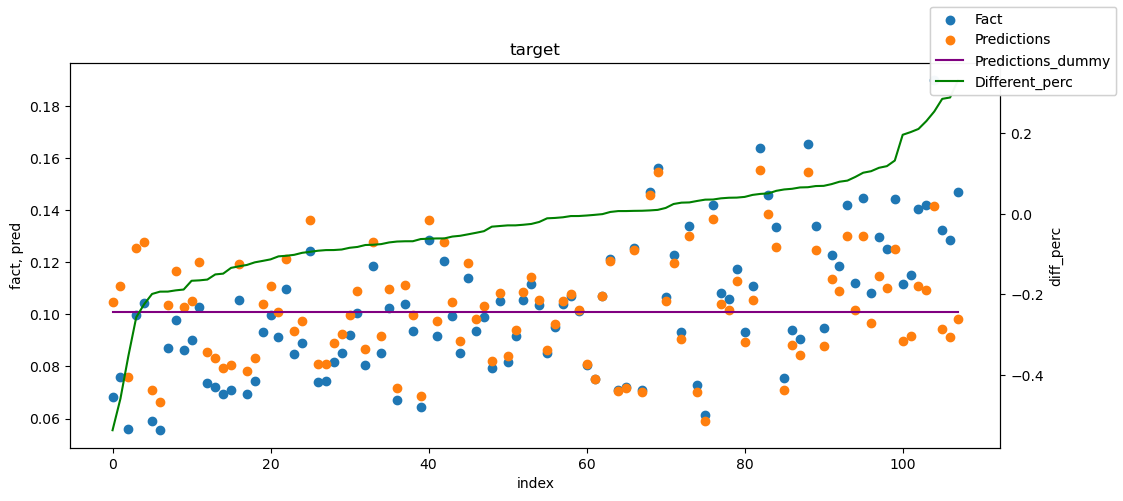

In [23]:
#Построим график для временного ряда
fig, graph1=plt.subplots(figsize=(12,5))
plt.title('target')
plt.xlabel('index');

graph2=graph1.twinx()

graph1.scatter(test_pred.index, test_pred['test'], label='Fact')
graph1.scatter(test_pred.index, test_pred['pred'], label='Predictions')
graph1.plot(test_pred.index, test_pred['dummy'], label='Predictions_dummy', c='purple')
graph2.plot(test_pred.index, test_pred['diff_perc'], label='Different_perc', c='green')

graph1.set_ylabel('fact, pred')
graph2.set_ylabel('diff_perc')

fig.legend();
fig.legend();

In [24]:
#Определим количество значений, у который разница меньше 15% относительных
count_values_15 = test_pred.loc[(test_pred['diff_perc']<=0.15) & (test_pred['diff_perc']>=-0.15), 'test'].count()
count_values_all = test_pred['test'].count()
print(f'Кол-во значений, где разница < 15% относительных: {count_values_15}')
print(f'Доля таких значений: {round(count_values_15/count_values_all*100, 2)}%')

Кол-во значений, где разница < 15% относительных: 86
Доля таких значений: 79.63%


In [25]:
#Определим количество значений, у который разница меньше 0.02
test_pred['diff'] = test_pred['test'] - test_pred['pred']
count_values_002 = test_pred.loc[(test_pred['diff']<=0.02) & (test_pred['diff']>=-0.02), 'test'].count()
count_values_all = test_pred['test'].count()
print(f'Кол-во значений, где разница < 0.02: {count_values_002}')
print(f'Доля таких значений: {round(count_values_002/count_values_all*100, 2)}%')

Кол-во значений, где разница < 0.02: 96
Доля таких значений: 88.89%
